# Using Machine Learning to Identify New Ternary Superconductors
### Sumner B. Harris

# I. Introduction

Machine learning techniques have the power to identify patterns in large amounts of data that no human could ever see. These methods can be used to predict the properties of new, unknown materials by training a model with databases of experimentally obtained target properties from known compounds. In this project, the superconducting transition temperature (Tc) is predicted for a list of never before synthesized compounds, having unknown crystal structures. A random forest model is trained with a database of experimentally determined Tc for known compounds. Machine learning features are generated based of simple metrics about the elements that each compound is composed of. This is important because using experimentally determined features, such as melting point, conductivity, etc., are not availble for totally unknown materials.

# II. Data Acquisition and Preprocessing

For this project, two databases are used to aquire a list of material names with their target property. The SuperCon database is a collection of all known superconducting compounds along with their experimentally measured Tc. The other database is the Materials project. From there, a list of ternary compounds with known structures is collected along with the target value of formation energy. In this section, the aquisition and processing of each dataset is discussed, starting with the superconductor dataset.

The SuperCon database can be found at https://supercon.nims.go.jp/index_en.html. More simply, the database can be directly downloaded from GitHub as a comma separated file here: https://github.com/vstanev1/Supercon. In the comma separated file ('SuperConData.csv'), there are two columns: material and Tc. 

In [1]:
import pandas as pd

tc_target = pd.read_csv('SuperConData.csv')
tc_target.head()

,material,T_c
0,Ba0.2La1.8Cu1O4,29.0
1,Ba0.1La1.9Ag0.1Cu0.9O4,26.0
2,Ba0.1La1.9Cu1O4,19.0
3,Ba0.15La1.85Cu1O4,22.0
4,Ba0.3La1.7Cu1O4,23.0


Because there are several classes of superconductors, it is possible to indentify them and train separate Tc prediction models. The SuperCon database was separated into three classes: Fe-based, Cuprates, and 'others'. It is likely that the 'others' class will contain a large number of BCS type superconductors. In addition to this, a model will also be trained with all classes combined. Below, the code used to classify the superconductors is shown. For every compound in the list, the name was checked to determine it contained both Cu and O. If so, the material is classified as a Cuprate. If the compound contained Fe, but not Cu and O, it was classified as an Fe-based compound. Everything else went into the 'others' class. The separated data was saved into json files for later use.

In [4]:
import json

Fe_based_list = []
Cuprates_list = []
Other_list = []

for i in range(len(tc_target)):
    if 'Cu' in tc_target['material'][i] and 'O' in tc_target['material'][i]:
        Cuprates_list.append([tc_target['material'][i], tc_target['T_c'][i]])
    else:
        if 'Fe' in tc_target['material'][i] and 'Cu' not in tc_target['material'][i] and 'O' not in tc_target['material'][i]:
            Fe_based_list.append([tc_target['material'][i], tc_target['T_c'][i]])
        else:
            Other_list.append([tc_target['material'][i], tc_target['T_c'][i]])

"""#Save the classified data for later.
with open('Fe_based_superconductors.json', 'w') as outfile:
    json.dump(Fe_based_list, outfile)

with open('Cuprate_superconductors.json', 'w') as outfile:
    json.dump(Cuprates_list, outfile)

with open('Other_superconductors.json', 'w') as outfile:
    json.dump(Fe_based_list, outfile)"""

print('There were',len(tc_target),'total superconductors in the SuperCon database.')
print('Of them,',len(Fe_based_list),'were Fe-based,',len(Cuprates_list), 'were Cuprates, and',len(Other_list),'were others.')
print(len(Fe_based_list)+len(Cuprates_list)+len(Other_list))

There were 21263 total superconductors in the SuperCon database.
Of them, 1251 were Fe-based, 10532 were Cuprates, and 9480 were others.
21263


# III. Feature Generation

60 ML features were created for each compound in both the SuperCon and MP database based on [1]. The features fall into 4 distinct categories: stoichiometric attributes, elemental-property-based attributes, valance orbital occupation attributes, and ionic compound attributes. Three features come from the stoichiometric attributes and capture the fraction of the elements present, without being affected by what elements they are. The $L^p$ norm is computed using $||x||=(\sum_i{|x_i|}^p)^{1/p}$ where $x_i$ is the element $i$'s atomic fraction. I used $p=0,2,3$ to generate the three stoichiometric features.
Next, there are 50 elemental-property-based attributes. They are the minimum, maximum, range, fraction-weighted mean, and average deviation of 10 different properties of each element in the material. The properties that these values are calculated for are: atomic mass, atomic number, column, row, atomic radius, electronegativity, and number of valence s,p,d, and f electrons. Four features come from the fraction weighted mean of the number of valence electrons in each orbital. Finally, the last 3 features are related to the ionic attributes between the elements. The first is a binary measure of whether it is possible to form an ionic bond. The other two are the electronegativity between elements $i$ and $j$:
$$ I(X_i, X_j) = 1-exp(-(X_i-X_j)^2/4)$$
and the mean ionic character:
$$\bar{I}=\sum{x_ix_jX_iX_j}$$

The code for feature generation was created previously and is imported using the Jupyter notebook importer "nbimporter."
First, the features for each class of superconductor are created and saved in json format for future use.

In [76]:
import nbimporter
from SBH_material_features_generator import material_features_generator

#Generate material features for the SuperCon Database
all_superconductor_features = []
Fe_based_features = []
Cuprate_features = []
Others_features = []

#Generate all superconductor features:
for i in tc_target['material']:
    all_superconductor_features.append(material_features_generator(i))

#Generate just Fe-based superconductor features
for i in Fe_based_list:
    Fe_based_features.append(material_features_generator(i[0]))

#Generate just Cuprate superconductor features
for i in Cuprates_list:
    Cuprate_features.append(material_features_generator(i[0]))

#Generate just other superconductor features
for i in Other_list:
    Others_features.append(material_features_generator(i[0]))

with open('All_superconductor_features.json', 'w') as outfile:
    json.dump(all_superconductor_features, outfile)
    
with open('Fe_based_superconductor_features.json', 'w') as outfile:
    json.dump(Fe_based_features, outfile)

with open('Cuprate_superconductor_features.json', 'w') as outfile:
    json.dump(Cuprate_features, outfile)

with open('Other_superconductors_features.json', 'w') as outfile:
    json.dump(Others_features, outfile)


The newly created files are then read by Pandas to create a DataFrame for each class. Each DataFrame is appened with a new column for the Tc value to complete the preprocessing of the superconductor dataset

In [5]:
import numpy as np

#import and assign the Tc as a new column in each DataFrame
superconductors_df = pd.read_json('All_superconductor_features.json')
Fe_based_df = pd.read_json('Fe_based_superconductor_features.json')
Cuprate_df = pd.read_json('Cuprate_superconductor_features.json')
Others_df = pd.read_json('Other_superconductors_features.json')

superconductors_df['Tc']=tc_target['T_c']
Fe_based_df['Tc']=np.array(Fe_based_list)[:,1]
Cuprate_df['Tc']=np.array(Cuprates_list)[:,1]
Others_df['Tc']=np.array(Other_list)[:,1]

# IV. Machine Learning Models

Random forest regression is used to fit models to both the superconductor data set and the MP ternary materials dataset. The target value for the superconductors is the Tc, while the target for the ternary materials is the binding energy.

## i. Training and validation
First, a random forest regression model is trained with all of the superconductor data as a first check of accuracy with default hyperparameters. The data is split into 75% training and 25% test sets for evaluating the default random forest.

In [6]:
from sklearn.model_selection import train_test_split
Xallsuper_train, Xallsuper_test, yallsuper_train, yallsuper_test = train_test_split(
        superconductors_df.values[:,:-2], superconductors_df.values[:,-1], random_state=42)
print(Xallsuper_train.shape, Xallsuper_test.shape, yallsuper_train.shape, yallsuper_test.shape)

from sklearn.ensemble import RandomForestRegressor

all_super_forest = RandomForestRegressor(n_estimators=100,random_state=42,n_jobs=-1)

all_super_forest.fit(Xallsuper_train,yallsuper_train)

print("Accuracy on training set: {:.3f}".format(all_super_forest.score(Xallsuper_train, yallsuper_train)))
print("Accuracy on test set: {:.3f}".format(all_super_forest.score(Xallsuper_test, yallsuper_test)))

(15947, 61) (5316, 61) (15947,) (5316,)
Accuracy on training set: 0.977
Accuracy on test set: 0.919


The accuracy with default parameters is already good, with a test set score of 0.919, but it may be slightly overfit because the trained accuracy is very high at 0.977. A 10-fold cross validation (CV) grid search is carried out to find the optimum decision tree depth by using various max_depth values in the range 5-15.

In [186]:
import time
from sklearn.model_selection import GridSearchCV

tree_max_depth = range(5,16)
parameters = {'max_depth': tree_max_depth}

all_super_forest = RandomForestRegressor(n_estimators=100,random_state=42,n_jobs=-1)

grid_search = GridSearchCV(all_super_forest, parameters, n_jobs=-1, cv=10)

t1=time.time()
print(t1)
grid_search.fit(superconductors_df.values[:,:-2],superconductors_df.values[:,-1])
t2=time.time()
print('Time for grid search with Forest (secs):', t2-t1)
print(grid_search.best_estimator_)
print(grid_search.best_score_)

1574349178.7619581
Time for grid search with Forest (secs): 519.5057888031006
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=15,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                      oob_score=False, random_state=42, verbose=0,
                      warm_start=False)
0.6775711868170494


The CV accuracy is poor, with a score of 0.678, which indicates that the first test was likely a case of overfitting. Upon further inspection of the CV results, the scores for each of the 10 splits greatly varied. This is because the SuperCon database was alphabetically ordered, resulting in large clusters of similar materials in different parts of the list.

In [187]:
print(grid_search.cv_results_)

{'mean_fit_time': array([19.55862124, 20.50428765, 22.98335176, 24.45370989, 27.09398403,
       28.75124679, 30.43333549, 33.49243562, 35.71267552, 37.11332123,
       35.82620013]), 'std_fit_time': array([3.41437392, 1.80263661, 1.17878088, 1.60244413, 1.71595956,
       1.27951026, 0.9706751 , 0.66335171, 1.71148513, 1.29468415,
       3.87757004]), 'mean_score_time': array([1.28434801, 3.48803327, 3.58300035, 4.57843072, 5.11172056,
       5.22806387, 5.42258749, 5.8568222 , 6.08748941, 5.86579201,
       3.92094998]), 'std_score_time': array([2.36587332, 1.66707909, 1.26656561, 1.33630875, 1.32866067,
       1.13619789, 1.08259047, 0.81527808, 1.06627218, 1.15698107,
       2.48148713]), 'param_max_depth': masked_array(data=[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
             mask=[False, False, False, False, False, False, False, False,
                   False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'max_depth': 5}, {'max_depth': 6}, {'max_d

In [7]:
from sklearn.utils import shuffle

X_allsuper,y_allsuper = shuffle(superconductors_df.values[:,:-2],superconductors_df.values[:,-1])

The SuperCon data was shuffled to fix the alphabetization problem and the CV grid search was repeated.

In [190]:
tree_max_depth = range(5,18)

parameters = {'max_depth': tree_max_depth}

all_super_forest = RandomForestRegressor(n_estimators=100,random_state=42,n_jobs=-1)

grid_search2 = GridSearchCV(all_super_forest, parameters, n_jobs=-1, cv=10)

t1=time.time()
grid_search2.fit(X_allsuper,y_allsuper)
t2=time.time()
print('Time for grid search using more parameters with Forest (secs):', t2-t1)
print(grid_search2.best_estimator_)
print(grid_search2.best_score_)

Time for grid search using more parameters with Forest (secs): 643.8967490196228
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=17,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                      oob_score=False, random_state=42, verbose=0,
                      warm_start=False)
0.9194222539093801


Shuffling the data results in a large improvement in the cross validation score, scoring 0.919 with the optimal tree depth of 17. With the optimized forest, the shuffled data is then split into 75/25% training and test sets to evaluate the accuracy.

In [8]:
Xallsuper_train, Xallsuper_test, yallsuper_train, yallsuper_test = train_test_split(
        X_allsuper, y_allsuper, random_state=42)
print(Xallsuper_train.shape, Xallsuper_test.shape, yallsuper_train.shape, yallsuper_test.shape)

from sklearn.ensemble import RandomForestRegressor

all_super_forest = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=17,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                      oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

all_super_forest.fit(Xallsuper_train,yallsuper_train)

print("Accuracy on training set: {:.3f}".format(all_super_forest.score(Xallsuper_train, yallsuper_train)))
print("Accuracy on test set: {:.3f}".format(all_super_forest.score(Xallsuper_test, yallsuper_test)))

(15947, 61) (5316, 61) (15947,) (5316,)
Accuracy on training set: 0.973
Accuracy on test set: 0.917


The results now score similarly to the 10-fold CV of 0.917. The training accuracy is still high at 0.973 but is reduced from the unshuffled data. The same process will be done for the 3 individual classes now. Each dataset will be shuffled from the start and a 10-fold CV is done to find the optimum tree depth.

In [193]:
X_Febased,y_Febased = shuffle(Fe_based_df.values[:,:-2],Fe_based_df.values[:,-1])
X_Cuprate,y_Cuprate = shuffle(Cuprate_df.values[:,:-2],Cuprate_df.values[:,-1])
X_others,y_others = shuffle(Others_df.values[:,:-2],Others_df.values[:,-1])

tree_max_depth = range(10,18)

parameters = {'max_depth': tree_max_depth}

Fe_forest = RandomForestRegressor(n_estimators=100,random_state=42,n_jobs=-1)
Cuprate_forest = RandomForestRegressor(n_estimators=100,random_state=42,n_jobs=-1)
Others_forest = RandomForestRegressor(n_estimators=100,random_state=42,n_jobs=-1)

grid_search_Fe = GridSearchCV(Fe_forest, parameters, n_jobs=-1, cv=10)
grid_search_Cuprate = GridSearchCV(Cuprate_forest, parameters, n_jobs=-1, cv=10)
grid_search_Others = GridSearchCV(Others_forest, parameters, n_jobs=-1, cv=10)

t1=time.time()
grid_search_Fe.fit(X_Febased,y_Febased)
t2=time.time()
print('Time for grid search using Fe-based SCs with Forest (secs):', t2-t1)
print(grid_search_Fe.best_estimator_)
print(grid_search_Fe.best_score_)

t1=time.time()
grid_search_Cuprate.fit(X_Cuprate,y_Cuprate)
t2=time.time()
print('Time for grid search using Cuprate SCs with Forest (secs):', t2-t1)
print(grid_search_Cuprate.best_estimator_)
print(grid_search_Cuprate.best_score_)

t1=time.time()
grid_search_Others.fit(X_others,y_others)
t2=time.time()
print('Time for grid search using other SCs with Forest (secs):', t2-t1)
print(grid_search_Others.best_estimator_)
print(grid_search_Others.best_score_)

Time for grid search using Fe-based SCs with Forest (secs): 23.651964902877808
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=14,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                      oob_score=False, random_state=42, verbose=0,
                      warm_start=False)
0.7559954582777342
Time for grid search using Cuprate SCs with Forest (secs): 197.89728832244873
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=17,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
               

The CV results for individual classes are not as good as the whole dataset together. The same result was found in [2] and is a geometric effect that the combined model outperforms the individual class models. Since each class generally lies in a different range of Tc, the combined model is a better predictor over the whole range. The CV score for the combined model (0.917) is greater than the R$^2$=0.88 value reported in [2] and the individual model scores are comparable. Below, the optimum random forest parameters are defined for the three classes.

In [195]:
Fe_forest = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=14,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                      oob_score=False, random_state=42, verbose=0,
                      warm_start=False)
Cuprate_forest = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=17,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                      oob_score=False, random_state=42, verbose=0,
                      warm_start=False)
Others_forest = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=17,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                      oob_score=False, random_state=42, verbose=0,
                      warm_start=False)


# V. Results, Discussion, and Prediction

Each of the optimum models for predicting Tc is evaluated with a 75/25% split and the R$^2$ and Pearson r values are computed.

In [458]:
from sklearn.metrics import r2_score
from scipy.stats import pearsonr

XFebased_train, XFebased_test, yFebased_train, yFebased_test = train_test_split(
        X_Febased, y_Febased, random_state=42)

XCuprate_train, XCuprate_test, yCuprate_train, yCuprate_test = train_test_split(
        X_Cuprate, y_Cuprate, random_state=42)

Xothers_train, Xothers_test, yothers_train, yothers_test = train_test_split(
        X_others, y_others, random_state=42)

Fe_forest.fit(XFebased_train,yFebased_train)
Cuprate_forest.fit(XCuprate_train,yCuprate_train)
Others_forest.fit(Xothers_train,yothers_train)

Febased_predicted, Febased_trained = Fe_forest.predict(XFebased_test), Fe_forest.predict(XFebased_train)
Cuprate_predicted, Cuprate_trained = Cuprate_forest.predict(XCuprate_test), Cuprate_forest.predict(XCuprate_train)
Others_predicted, Others_trained = Others_forest.predict(Xothers_test), Others_forest.predict(Xothers_train)
All_predicted, All_trained = all_super_forest.predict(Xallsuper_test), all_super_forest.predict(Xallsuper_train)

pearsR_Febased = pearsonr(yFebased_test.astype(float),Febased_predicted)[0]
pearsR_Cuprate = pearsonr(yCuprate_test.astype(float),Cuprate_predicted)[0]
pearsR_Others = pearsonr(yothers_test.astype(float),Others_predicted)[0]
pearsR_All = pearsonr(yallsuper_test.astype(float),All_predicted)[0]
r2_Febased = r2_score(yFebased_test,Febased_predicted)
r2_Cuprate = r2_score(yCuprate_test,Cuprate_predicted)
r2_Others = r2_score(yothers_test,Others_predicted)
r2_All = r2_score(yallsuper_test, All_predicted)

The training test scores for the split data are computed. The $R^2$ value for each class idividually are: 0.839 for cuprates, 0.764 for the Fe-based compounds, and the lowest of 0.746 for everything else. These values are similar to [2], with worse performance in the 'others' class because my data was not filtered to include only "low-Tc" materials (Tc < 10 K).

In [460]:
Fe_forest.fit(XFebased_train,yFebased_train)
Cuprate_forest.fit(XCuprate_train, yCuprate_train)
Others_forest.fit(Xothers_train, yothers_train)

print("Fe-based accuracy on training set: {:.3f}".format(Fe_forest.score(XFebased_train, yFebased_train)))
print("Fe-based accuracy on test set: {:.3f}".format(Fe_forest.score(XFebased_test, yFebased_test)))

print("Cuprate accuracy on training set: {:.3f}".format(Cuprate_forest.score(XCuprate_train, yCuprate_train)))
print("Cuprate ccuracy on test set: {:.3f}".format(Cuprate_forest.score(XCuprate_test, yCuprate_test)))

print("Others accuracy on training set: {:.3f}".format(Others_forest.score(Xothers_train, yothers_train)))
print("Others accuracy on test set: {:.3f}".format(Others_forest.score(Xothers_test, yothers_test)))

Fe-based accuracy on training set: 0.908
Fe-based accuracy on test set: 0.764
Cuprate accuracy on training set: 0.946
Cuprate ccuracy on test set: 0.839
Others accuracy on training set: 0.939
Others accuracy on test set: 0.746


The test data is visualized for all for cases below. In each plot, the Tc predicted by each model is plotted against the measured value.

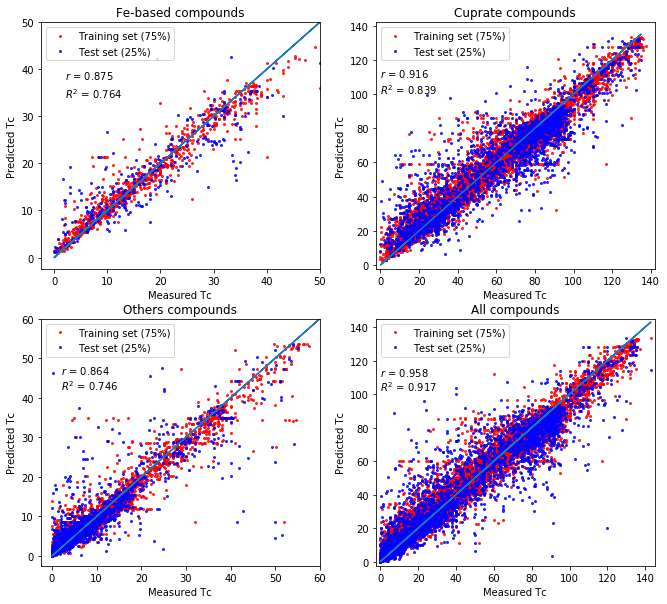

In [461]:
import matplotlib.pylab as pl
import matplotlib.gridspec as gridspec
# Create 2x2 sub plots
gs = gridspec.GridSpec(2, 2)
pl.figure(figsize=(11,10))

ax = pl.subplot(gs[0, 0])
pl.plot(yFebased_train.astype(float),Febased_trained,'o',markersize=2, alpha=0.8,color='r',label='Training set (75%)')
pl.plot(yFebased_test.astype(float),Febased_predicted,'o',markersize=2,alpha=0.8,color='b', label='Test set (25%)')
pl.plot(yFebased_test.astype(float),yFebased_test.astype(float))
pl.xlabel('Measured Tc')
pl.ylabel('Predicted Tc')
pl.title('Fe-based compounds')
pl.text(2,38,f'$r$ = {pearsR_Febased:.3f}')
pl.text(2,34,f'$R^2$ = {r2_Febased:.3f}')
plt.xlim(-2.5,50)
plt.ylim(-2.5,50)
pl.legend(loc='upper left')

ax = pl.subplot(gs[0, 1])
pl.plot(yCuprate_train.astype(float),Cuprate_trained,'o',markersize=2, alpha=0.8,color='r',label='Training set (75%)')
pl.plot(yCuprate_test.astype(float),Cuprate_predicted,'o',markersize=2,alpha=0.8,color='b', label='Test set (25%)')
pl.plot(yCuprate_test.astype(float),yCuprate_test.astype(float))
pl.xlabel('Measured Tc')
pl.ylabel('Predicted Tc')
pl.title('Cuprate compounds')
pl.text(0,110,f'$r$ = {pearsR_Cuprate:.3f}')
pl.text(0,100,f'$R^2$ = {r2_Cuprate:.3f}')
plt.xlim(-2.5,142)
plt.ylim(-2.5,142)
pl.legend()

ax = pl.subplot(gs[1, 0])
pl.plot(yothers_train.astype(float),Others_trained,'o',markersize=2, alpha=0.8,color='r',label='Training set (75%)')
pl.plot(yothers_test.astype(float),Others_predicted,'o',markersize=2,alpha=0.8,color='b', label='Test set (25%)')
pl.plot(yothers_test.astype(float),yothers_test.astype(float))
pl.xlabel('Measured Tc')
pl.ylabel('Predicted Tc')
pl.title('Others compounds')
pl.text(2,46,f'$r$ = {pearsR_Others:.3f}')
pl.text(2,42,f'$R^2$ = {r2_Others:.3f}')
plt.xlim(-2.5,60)
plt.ylim(-2.5,60)
pl.legend()

ax = pl.subplot(gs[1, 1])
pl.plot(yallsuper_train.astype(float),All_trained,'o',markersize=2, alpha=0.8,color='r',label='Training set (75%)')
pl.plot(yallsuper_test.astype(float),All_predicted,'o',markersize=2,alpha=0.8,color='b', label='Test set (25%)')
pl.plot(yallsuper_test.astype(float),yallsuper_test.astype(float))
pl.xlabel('Measured Tc')
pl.ylabel('Predicted Tc')
pl.title('All compounds')
pl.text(0,111,f'$r$ = {pearsR_All:.3f}')
pl.text(0,102,f'$R^2$ = {r2_All:.3f}')
plt.xlim(-2.5,145)
plt.ylim(-2.5,145)
pl.legend()

plt.show()
#plt.savefig('All_SC_model_predictions.png', bbox_inches='tight', dpi=600)

If a class specific model is used to predict the Tc of a material from a different class, the results are very poor. See below where the 'others' model is used to predict the Tc for Fe-based and cuprates and the cuprate model is used to predict the other two. The 'others' model tends to underestimate the Tc for the other two classes while the cuprate model greatly overestimates.

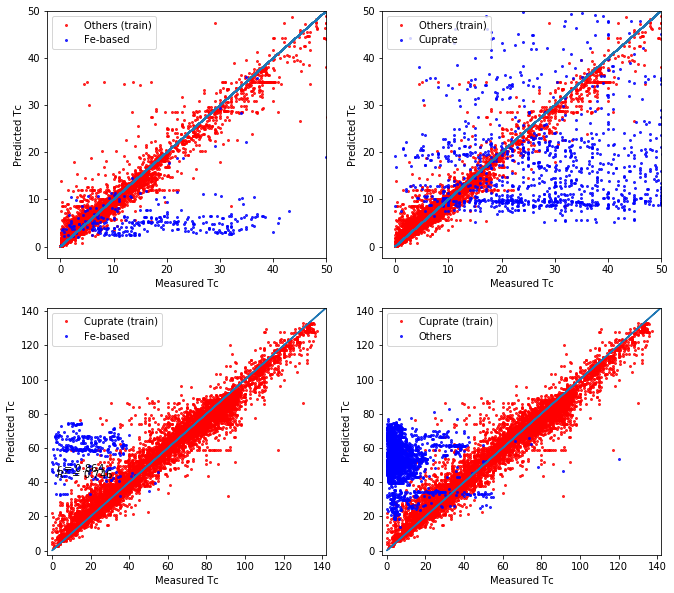

In [467]:
Others_Fe_predicted = Others_forest.predict(XFebased_test)
Others_Cu_predicted = Others_forest.predict(XCuprate_test)
Cuprate_Fe_predicted = Cuprate_forest.predict(XFebased_test)
Cuprate_others_predicted = Cuprate_forest.predict(Xothers_test)

gs = gridspec.GridSpec(2, 2)
pl.figure(figsize=(11,10))

ax = pl.subplot(gs[0, 0])
pl.plot(yothers_train.astype(float),Others_trained,'o',markersize=2, alpha=0.8,color='r',label='Others (train)')
pl.plot(yFebased_test.astype(float),Others_Fe_predicted,'o',markersize=2,alpha=0.8,color='b', label='Fe-based')
pl.plot(yothers_train.astype(float),yothers_train.astype(float))
pl.xlabel('Measured Tc')
pl.ylabel('Predicted Tc')
plt.xlim(-2.5,50)
plt.ylim(-2.5,50)
pl.legend(loc='upper left')

ax = pl.subplot(gs[0, 1])
pl.plot(yothers_train.astype(float),Others_trained,'o',markersize=2, alpha=0.8,color='r',label='Others (train)')
pl.plot(yCuprate_test.astype(float),Others_Cu_predicted,'o',markersize=2,alpha=0.8,color='b', label='Cuprate')
pl.plot(yothers_train.astype(float),yothers_train.astype(float))
pl.xlabel('Measured Tc')
pl.ylabel('Predicted Tc')
plt.xlim(-2.5,50)
plt.ylim(-2.5,50)
pl.legend(loc='upper left')

ax = pl.subplot(gs[1, 0])
pl.plot(yCuprate_train.astype(float),Cuprate_trained,'o',markersize=2, alpha=0.8,color='r',label='Cuprate (train)')
pl.plot(yFebased_test.astype(float),Cuprate_Fe_predicted,'o',markersize=2,alpha=0.8,color='b', label='Fe-based')
pl.plot(yCuprate_train.astype(float),yCuprate_train.astype(float))
pl.xlabel('Measured Tc')
pl.ylabel('Predicted Tc')
pl.text(2,46,f'$r$ = {pearsR_Others:.3f}')
pl.text(2,42,f'$R^2$ = {r2_Others:.3f}')
plt.xlim(-2.5,142)
plt.ylim(-2.5,142)
pl.legend()

ax = pl.subplot(gs[1, 1])
pl.plot(yCuprate_train.astype(float),Cuprate_trained,'o',markersize=2, alpha=0.8,color='r',label='Cuprate (train)')
pl.plot(yothers_test.astype(float),Cuprate_others_predicted,'o',markersize=2,alpha=0.8,color='b', label='Others')
pl.plot(yCuprate_train.astype(float),yCuprate_train.astype(float))
pl.xlabel('Measured Tc')
pl.ylabel('Predicted Tc')
plt.xlim(-2.5,142)
plt.ylim(-2.5,142)
pl.legend()

plt.show()

These results indicate that the separate groups have different weights given to different sets of features. To visualize this, the feature importance is extracted from each model and plotted.

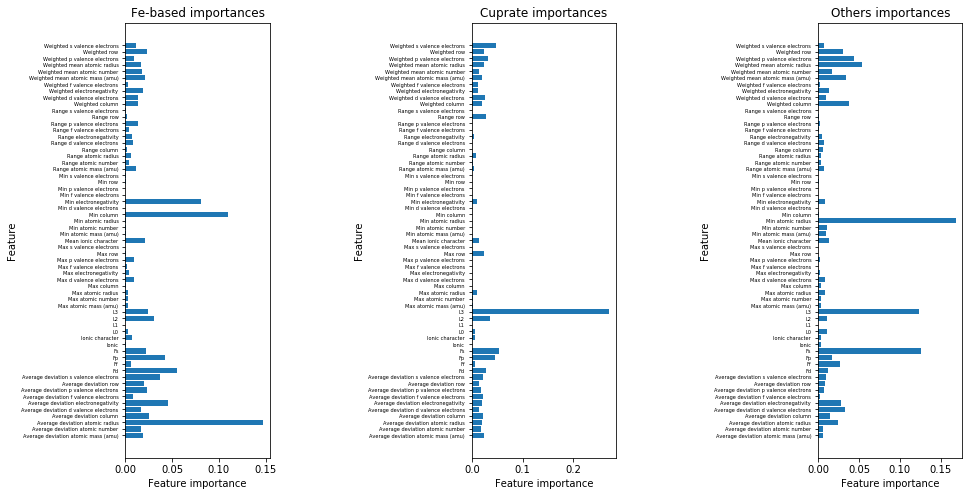

In [487]:
import numpy as np
%matplotlib inline
def plot_feature_importances(model):
    n_features = superconductors_df.keys().shape[0]-2
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), superconductors_df.keys()[:-2],fontsize=5)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")

gs = gridspec.GridSpec(1, 5)
pl.figure(figsize=(15,8))

ax = pl.subplot(gs[0, 0])
plot_feature_importances(Fe_forest)
plt.title('Fe-based importances')

ax = pl.subplot(gs[0, 2])
plot_feature_importances(Cuprate_forest)
plt.title('Cuprate importances')

ax = pl.subplot(gs[0, 4])
plot_feature_importances(Others_forest)
plt.title('Others importances')

plt.show()

The most important features for the Fe-based compounds are: Average deviation of atomic radius, minimum column number, and minimum electronegativity. For the cuprates, a high importance is given to the $L^3$ norm, followed by the fractions of d and f electrons. Finally, all the others are weighted by the minimum atomic radius, fraction of f electrons and the $L^3$ norm.

Principal component analysis (PCA) is used to visualize the the feature space along 3 components. The classified data is scaled scaled using the scikit-learn StandardScaler. 

In [265]:
import numpy as np
import pandas as pd
data = pd.read_json('Superconductor_material_featues.json')
target = pd.read_csv('SuperConData.csv')
ls = np.zeros(len(target.material))
target.insert(2,'Class', ls,True)
classified = target.values

for i in classified:
    if 'Cu' in i[0] and 'O' in i[0]:
        i[2] = 1
    else:
        if 'Fe' in i[0] and 'Cu' not in i[0] and 'O' not in i[0]:
            i[2] = 2


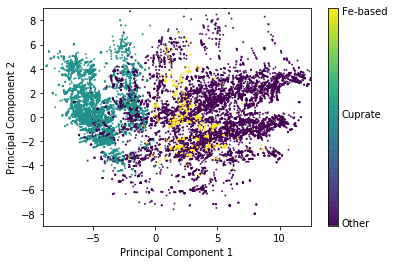

In [267]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

class_data = pd.DataFrame(classified)
X,y = data.values[:,0:-1],class_data[2]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=3)
pca.fit(X_scaled)
xpca=pca.transform(X_scaled)

plt.scatter(xpca[:,0],xpca[:,1],s=1,c=y,alpha=0.8)
plt.xlim(-9,12.5)
plt.ylim(-9,9)
plt.colorbar(ticks=[])
plt.text(15,0,'Cuprate')
plt.text(15,8.5,'Fe-based')
plt.text(15,-9,'Other')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

plt.show()

When the 1st and 2nd prinicpal components are plotted against each other, a clear separation between the cuprates and others is seen. The Fe-based compounds are well intermixed with the other class. Visualizing three prinicpal components reveals a "pocket" where the majority of Fe-based compounds are centered.

(-7, 10)

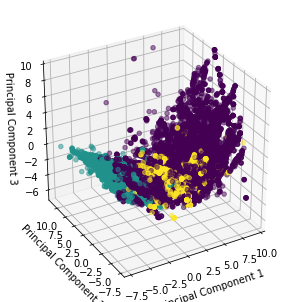

In [256]:
fig = plt.figure(1, figsize=(4, 4))
plt.clf()
ax = Axes3D(fig, elev=30, azim=240)

ax.scatter(xpca[:, 0], xpca[:, 1], xpca[:, 2], c=y,depthshade=True, alpha=0.5)
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_xlim(-8,10.2)
ax.set_ylim(-8,12)
ax.set_zlim(-7,10)


The coefficients of each feature along the principal components is visualized below. All three components involve all of the features with mixed signs.

(2.5, -0.5)

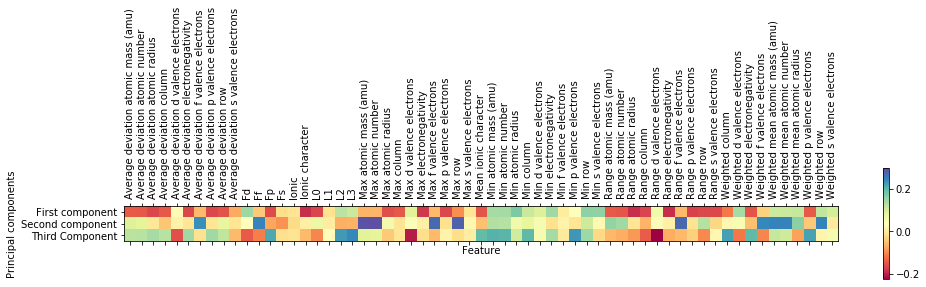

In [274]:
plt.matshow(pca.components_, cmap='Spectral')
plt.yticks([0, 1, 2], ["First component", "Second component", "Third Component"])
plt.colorbar()
plt.xticks(range(len(data.keys()[:-1])),
           data.keys()[:-1], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Principal components")
plt.ylim(2.5,-0.5)

Clustering was attempted using DBSCAN. While the clustering effectively assigns several different classes, they do not match the manually assigned classes. The cuprates are well separated and DBSCAN correctly clusters them together, but everything else is split into 4 separate classes. It does not appear that the Fe-based compounds can be distinguished with this method. With further investigation of the data, excluding cuprates, it may be revealed that the other classes idetified by DBSCAN may be related to type I and type II BCS superconductors or other types.

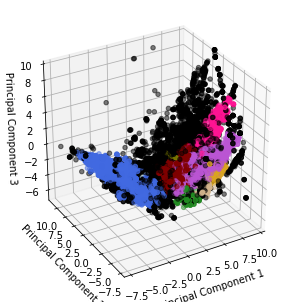

Text(0, 0.5, 'Principal Component 2')

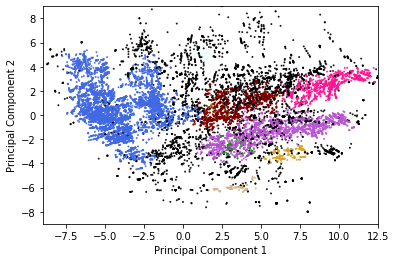

In [260]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.89, min_samples=90,n_jobs=-1)
clustered = dbscan.fit_predict(xpca)

fig = plt.figure(1, figsize=(4, 4))
plt.clf()
ax = Axes3D(fig, elev=30, azim=240)

colors = ['royalblue', 'maroon', 'forestgreen', 'mediumorchid','tan', 'deeppink','olive', 'goldenrod','lightcyan','black']
vector =np.vectorize(lambda x: colors[x % len(colors)])
clusters=dbscan.labels_

ax.scatter(xpca[:, 0], xpca[:, 1], xpca[:, 2], c=vector(clusters),depthshade=True, alpha=0.5)
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_xlim(-8,10.2)
ax.set_ylim(-8,12)
ax.set_zlim(-7,10)
#plt.ylim(-10,12)
plt.show()

plt.scatter(xpca[:,0],xpca[:,1],s=1,c=vector(clusters),alpha=0.8)
plt.xlim(-9,12.5)
plt.ylim(-9,9)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# VI. Prediction of Tc for unknown compounds

A list of ternary compounds, which have been predicted to be stable but whose structure is unknown was provided. The same meachine learning features were generated for these compounds and then the machine learning model was used to predict the Tc. The random forest model for all superconducting compounds was used for prediction.

In [9]:
import nbimporter
from SBH_material_features_generator import material_features_generator

terns = pd.read_csv('unknown_ternary_data_all.txt')

terns_feat = []
for i in np.reshape(terns.values,(-1,)):
    terns_feat.append(material_features_generator(i))

Importing Jupyter notebook from SBH_material_features_generator.ipynb


In [10]:
terns_df = pd.DataFrame(terns_feat)
print(terns_df.shape)
terns_df.head()

(4521, 62)


,Average deviation atomic mass (amu),Average deviation atomic number,Average deviation atomic radius,Average deviation column,Average deviation d valence electrons,Average deviation electronegativity,Average deviation f valence electrons,Average deviation p valence electrons,Average deviation row,Average deviation s valence electrons,...,Weighted d valence electrons,Weighted electronegativity,Weighted f valence electrons,Weighted mean atomic mass (amu),Weighted mean atomic number,Weighted mean atomic radius,Weighted p valence electrons,Weighted row,Weighted s valence electrons,formula
0,5.863527,1.214286,0.307143,0.785714,0.000000,1.071429,0.142857,1.285714,0.285714,0.0,...,0.000000,2.637143,0.714286,93.661436,38.071429,1.064286,2.428571,4.571429,2.0,O8Si1Pa5
1,128.322181,51.230769,1.223077,4.461538,0.923077,2.938462,10.769231,5.384615,5.230769,0.0,...,0.692308,3.216154,1.076923,38.219241,16.923077,0.792308,3.461538,2.923077,2.0,F9V3Yb1
2,39.571462,14.400000,0.030000,1.200000,0.000000,0.204000,1.000000,0.000000,1.000000,0.0,...,0.000000,2.308000,2.000000,107.228424,42.800000,1.160000,2.000000,5.000000,2.0,O2Si1U2
3,39.365680,14.600000,0.030000,1.000000,0.000000,0.200000,0.800000,0.000000,1.000000,0.0,...,0.000000,2.300000,1.600000,106.816860,43.200000,1.160000,2.000000,5.000000,2.0,O2Si1Np2
4,18.493727,7.500000,0.007143,0.785714,0.000000,0.560714,0.142857,1.285714,0.500000,0.0,...,0.000000,2.683571,0.714286,92.513236,37.500000,1.035714,2.428571,4.500000,2.0,C1O8Pa5


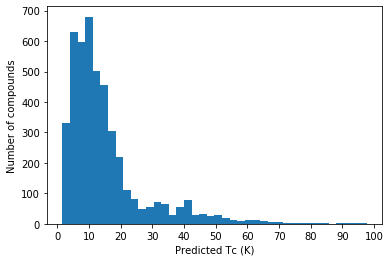

In [12]:
import matplotlib.pyplot as plt
terns_feat = terns_df.values[:,0:-1]

terns_Tc_predicted = all_super_forest.predict(terns_feat)

plt.hist(terns_Tc_predicted, bins=40)
plt.xlabel('Predicted Tc (K)')
plt.ylabel('Number of compounds')
plt.xticks(np.linspace(0,100,11))
plt.show()

The majority of the compounds predicted have a Tc that falls below 30 K but there are a few with very high Tc. There are 8 coumpounds with Tc predicted above the boiling point of liquid nitrogen, 77K. They all take on a formula that includes H and O with another element, for example, TeO5H8.

In [16]:
terns_df['Predicted Tc'] = terns_Tc_predicted
lessthan30 = []
between30and77 = []
above77 = []
for i in range(len(terns_df['formula'])):
    if terns_df['Predicted Tc'][i] >= 77:
        """print(terns_df['formula'][i], terns_df['Predicted Tc'][i])"""
        above77.append([terns_df['formula'][i], terns_df['Predicted Tc'][i]])
    if  30 < terns_df['Predicted Tc'][i] < 77:
        between30and77.append([terns_df['formula'][i], terns_df['Predicted Tc'][i]])
        
    if terns_df['Predicted Tc'][i] <= 30:
        lessthan30.append([terns_df['formula'][i], terns_df['Predicted Tc'][i]])
        print(terns_df['formula'][i], terns_df['Predicted Tc'][i])
        

O8Si1Pa5 13.930820409976823
F9V3Yb1 15.535915595238093
O2Si1U2 21.551608633807945
O2Si1Np2 21.55264000985125
C1O8Pa5 13.840021010032054
O5S1Pa2 7.479134014795324
O8P4Hf1 6.489112771708568
O9Yb5Au1 18.733588448621557
C1F5Yb3 13.029957958251794
O9I1Yb5 12.152744719519715
O9Br1Yb5 12.388208951121447
O9Se1Eu4 8.954084582595913
F7S2Tm1 17.316029534632033
O8Se1Yb4 12.207077183345845
O8Cl1Tm3 10.959045090856032
O6V4Pa1 14.42890070808991
F7Ru2Tl1 7.179832550863451
O9P5Ti1 12.345607964753404
O4P2Nb1 13.690124682009113
O2Si1Pu2 18.50109256516187
O8Fe6U1 14.273593083491459
N1O9Yb5 14.867587406873344
O8P4Pu1 9.819159994933218
F6S2Cr1 25.394493192458654
F8S3Nb1 27.95555347701149
O8Cl1Tb3 10.330494030249973
O8Cl1Dy3 11.218503836678915
O9S1Yb4 11.146854751651858
O9P5Ac1 13.291206890197358
O8Cl1Pm3 10.240834263111683
F9S3Yb1 23.25930643939394
O9P5Pm1 12.226076628532496
F3S1Ta1 4.711102748586765
O9Te1Eu4 8.982737970041802
O8Ba6Os1 14.49835252361689
O9I1Eu5 10.726243630902452
N1O7Tb3 9.968389030249972
F

F8I5Tm1 9.538712020590523
O9Rh1Pa3 7.830846395356758
F9Ti3Dy1 14.367728117581084
F9I5Pa1 9.034332910965027
F8Ag6Eu1 24.412431126265552
F8Mg1I6 7.54324826951952
O8Nb3Pu1 16.27212412250792
O8P4Th1 9.55360722984138
O9Mn5Ru1 13.659657568134177
O8P4Zr1 10.669306471679434
N1F9Ce2 15.01871190177638
O8Sr6Re1 13.980681484663307
F2Sn1Tl2 12.964708600713013
O8Re1Pa3 12.136750992701895
F8S3Cd1 19.84460751380804
O9P5Lu1 12.241360878610328
F8S3Pb1 7.460375593938429
O8Mg6Re1 9.635300576086522
O9Se1Pa3 7.340993131823126
O8Ag1Yb5 20.770285401002507
O8S5Mo1 9.754432055456839
C1F5Y3 13.804400524923386
O8Tc1Eu4 14.701419619758498
F8Zn1I6 5.847960972362427
O8Ba6W1 18.898934725006605
F9S4Hg1 17.79886489020448
O9Rh1Eu5 15.044207356506021
C1O4Ce4 16.09926722369057
Be1F6S2 9.562395000000004
F8Sn1Yb4 11.576446930682874
F9Ti3Yb1 17.600675598555206
O8Mn6Pu1 13.017199419133833
F8V3Sr1 6.645767071886446
O7Cd1Yb4 16.521857219519717
O6Se1Sm2 9.572249793414715
O9P5Ga1 12.082603454420497
O8Ru1Pu3 14.128423319519719
Li9

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




F8Ag5Nd1 16.3355469047619
C1O2Pu2 18.69688465727741
Ni1Se9Pm5 6.549102145575691
S9Rh1Pm5 7.764744710529351
O4Co4Sn1 10.993096108300099
F9Sr2Ta1 18.226783384740255
O7Hg1U2 7.5196161541443765
F9Se3Ce1 13.611816212121216
B1F7Pd2 19.048504030602768
O8Nb1Rh4 10.275144421281027
Cl3As2Er1 9.005993414752593
Li3Cl9Se1 14.495784194117649
F9Pt4Hg1 8.525380136778253
F3P2Sb1 5.032630772886307
Se9Sb1Pm5 5.995298284626338
O6Co4Tc1 12.398043245979249
N1Te4Dy1 8.492296840994438
O9Pm1Ta3 7.209447100395505
O7Mg1Yb4 16.878878121159055
F3Cu1Se1 14.657747457627488
Cl7Ti2Sm1 4.462743717420223
O9Cd1Re4 2.8130802359350264
O8Ce3Os1 13.696687924404623
O5Cu7Yb1 20.24380670869481
S8Se1Ac4 9.486867459595517
O5K7Rh1 16.80497355294485
O9Sc1Ru5 10.586757500000003
F8Cd1Te3 5.727466251243548
F9Na1Co4 14.174022821316619
Na1S8Pm5 6.696623500885428
F9Ba2Ta1 19.360189545454542
F8Cl4Pd1 17.99916095240702
F9Nb1Ag4 11.633059060606065
S9Co1Pm5 6.912666164372411
Ge1Se7Pm4 5.663972005575561
O6Ca4Tc1 14.752852613858366
F6Cl3Co1 1

O1Ti6Te8 4.401421792847846
N7I1Np5 12.300134995044868
O6Co5Ba1 6.629217078899153
S8Pm4Re1 6.025601001155845
F9Tc1Cs5 19.086323031400966
O6Ti2Pd1 11.147095481624126
H1O7Fe5 27.512928605282838
F8Ru2Ba1 7.9375958424908415
N1Cl9Sr2 9.137401443487827
O8Cr3Pt1 10.499322979731382
Li9O5Rb1 24.969413833333338
Mg3Cl9Ir1 4.189375999999999
Si5Cl6Cd1 5.2018684765088725
O9Al1Co5 14.417420175069687
Se7Cd1Pm4 5.152601848514388
O8I1Tl5 4.613178902078406
F8Ge1I6 4.064559360747272
O8P5K1 21.947780303030303
Si7Cl5Tl1 3.1548321880490824
O6Na6Se1 19.83230657572562
O9Rh5Tl1 9.730448637544058
O6Nd3Tl1 13.776966523470035
Si2S2Pu1 8.385560833292251
F1Tc1Sb1 17.150050782032295
N8Ce5Pt1 9.54937122539558
O8Na1P5 21.97101347402598
Br9Cs4Ta1 23.380054977591044
O8Zr1Tc3 5.425747027194745
O8Sc3Tc1 11.079233010933518
O8Fe4Os1 7.6726560763503855
O5Os1Ac2 14.680434009198775
P2Cl4Ba1 7.3583872470716685
Na5Br9Ir1 12.336251358572774
S2I7Yb1 5.196575208786601
N8S1La6 7.827853651753111
Se7Sn1Pm4 5.245264290975545
O7Co5Se1 8.4

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




S9Nd1Pm5 6.269178225807659
Na5Cl9Ru1 12.626238183989726
B1Cl9Lu2 9.26870126279052
O5Ca3W1 18.70211645449142
N8Ge1Pu5 16.499483336025975
O5Cu7Lu1 17.962727512177874
Be1F5Cu3 24.495113713698576
Be1S7Ac4 9.42773932990841
N5Nd4Bi1 19.065172236069248
O8As5Tl1 3.952843764188568
P3Cl6Tm1 4.567065434763931
O9Ho1Ir5 13.81555909897292
S1As8Pu5 10.252798002985008
Se1Br6Sr2 6.87114715613796
P1Sc3Se6 7.9552942371614686
Li7O5As1 24.9053608797654
O7Mo2Pd1 7.3095637501419946
S9Co1Yb5 8.248613111346858
Cl5Sn7Tl1 3.341146606160764
B3O6Ho1 19.354396622642962
Mg2Cl8Pt1 6.036232666666666
Zn1Se7Pm4 5.561995558256213
S9I1Ac5 9.301840701007375
S2I7Ho1 4.074181983211887
Ti2Y1I7 3.9821361204886823
F9I5Th1 9.89285362412442
O9Sb5Pr1 8.838427340100226
Cl7Er1Hg4 3.092109790023969
F7I4Au1 5.409598765383931
O8Fe4Pt1 8.840859071916649
Cl1As7Ce4 4.496461080697555
Li8O5Ti1 25.287628488178495
O9Ga5Nd1 14.279481293091681
O9Cr1Fe4 15.820127651515147
Si1K5I9 9.05134942592303
F9Na5Pb1 12.90471261510453
O9Ru5Lu1 15.062035563

O8Yb4Np1 17.14788691716869
O8K1Co5 10.472866421064316
N8Ru1Pu5 15.665633283672337
F9Cl3U1 20.92448202762924
Cl5Sn7Gd1 3.542488405767131
P2Sb1Pm1 13.86439678117844
P1K5I8 9.514530992821046
Li3N1Br8 13.318572876634716
Cl5V1Sb6 7.841515948073571
S9Ge1Pu4 9.678509144741657
Se7Sb1Ac3 4.624420384382344
O8Si1Mn3 10.728384950219601
Se7Lu3Ta1 2.9518619779229285
S9Co1Pu4 8.649858078407282
Cl5Sn7Nd1 3.348841952143415
Si4Cl5K1 13.096030555555565
N8Ce5Re1 9.812164815364007
Y1Pt1Bi1 1.6102172941740935
Na5Cl9Pa1 16.37821927676125
F1Te7Ta3 4.412140032694722
N1F7Ni5 8.258017745087392
Br8Ba2Re1 29.194492303493302
O8Mo1Ta2 4.235592893285357
N1I6Ho1 10.09823981779576
N8Os1Np5 12.749899300889522
N9Co1Np5 12.428616751771479
Cl8Hg4Np1 7.014283613076121
O8Ti1Ir3 6.506885415451287
O5Ca3Pd1 21.397697107050828
N9Ni1Np5 12.458444529549258
Ru1Te9Pm5 2.379721555196577
N8Ir1Pu5 15.112324798823852
F9Rb5Mo1 17.923031732323228
Fe1Se6Ac3 4.610558161252747
B1Na5I8 9.16221112073229
Ti1Se9Pm5 6.8010424443636275
S9Pb1Pu4 9.

S8Ce1Pt6 7.421506376105972
C1O2Na8 28.516414365079363
N8Os1Pu5 16.130884798823853
Cl8V1Ba2 29.75985188435415
Mn1As6Eu5 16.52101448922302
N1Ti1Br6 9.13173241382201
Mg1Se7Pm4 6.198850539501873
N8Mo1Np5 14.503311153413208
Be1Se7Y4 5.311482380164997
O8Cr1Ba5 6.884269215137671
C1O4S6 4.844057906292563
Ge1Pd2Pu1 2.607791800959219
S5As1Rb5 15.847018976007202
S1Sb4Nd2 12.128574728474801
Cr5Se7Hf1 4.492398137422686
Pd2Cd2Tm1 2.0478504884633866
Na7Si1Br3 10.7844345777254
S6Zr1Sn7 7.221636867564537
S1Te5Ho2 5.399721993316221
Mg1S7Ac4 8.909066203996682
Y1Rh2Bi1 2.6976556156949796
S8Pt6Th1 7.965880840391686
O5Zn3Pd1 16.98150914529612
S3Tm1Ir1 7.901069910246985
Se9Pm4U1 5.34043110961895
Li3N1Cl8 23.556616354707117
Se8Ru1Pu3 3.133511525925254
N1P6Nb3 6.0782609003836505
V1Se7Y4 4.122162765173995
Ge1Ir1Ac1 3.8432517559700883
O8Ga3I1 4.436682519018168
N4Nd3Ir1 18.731444646665288
Cl2Sb1Ta1 7.299539208314366
O1Zr5Sb6 15.229476368948555
O8Mn1La3 16.073006206633043
Co1As7Pm6 7.723987153299726
N3Ho2Au1 17.91

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



C1O3Re2.5 19.61618941036116
C1O3W2.5 18.704534851825148
C3O4.5As1 22.487011568872518
C3O4.5P1 26.88846034379427
Ca1.5As2Bi1 9.529152513418378
Ca1.5Se5I1 5.14534124686835
Ca1Se1.5Te2.5 5.164250816142776
Ca2.5Se4.5Ir1 10.593620113746567
Ca2Se4.5Br1 7.457030600227767
Ca2Te5.5I1 5.404986213401259
Cl1.5Br2.5Rb1 11.204553996282533
Cl1.5I1.5Tl1 8.158849626043066
Cl1.5K1Br2.5 12.250365107393643
Cl1.5Sb1.5W1 6.708010749874708
Cl1.5Sb1Bi1.5 5.752355000000001
Cl1Br6Sr1.5 7.372206966888801
Cl1Ca1.5I6 5.4387809414055175
Cl1Ca2.5Se6 8.525988726943883
Cl1Ca2Te4.5 7.745922904842838
29.428538759363242
H2.5C1F1.5 29.349337285714288
Li1O4.5Hf2 12.051403087771858
Li1O4.5Pu2 21.525776219481408
Li2P1Te2.5 8.581313134007228
Li3S1Se3.5 5.400683219410951
Li3S1Te4.5 5.674903800783077
Li3Se1Te4.5 5.8481514287165455
Li6O3.5K1 25.47778116666667
Mg1.5Cl7W1 4.917846
Mg3.5Se6Br1 7.274244072087552
Mg3As1Te5.5 5.721784904900538
Mg3P1Te4.5 5.774668119719913
Mn1Se5.5Ho3 5.832555645818778
N1.33333333P2.66666667Hf1 12.5569

In [14]:
print('There are',len(lessthan30), 'with Tc below 30 K')
print('There are',len(between30and77), 'with Tc between 30 K and 77 K')
print('There are',len(above77), 'with Tc above 77 K')

There are 4000 with Tc below 30 K
There are 513 with Tc between 30 K and 77 K
There are 8 with Tc above 77 K


# VII. Conclusion

Using the random forest machine learning technique, the SuperCon database was used to train a several models. All of the compounds in the database were used with a 10-fold CV accuracy of 0.919. The databased was manually classified into cuprate, Fe-based, and other compounds and were fit separately with a random forest with CV scores of 0.76, 0.83, 0.80, respectively. Each subclass has worse score than the full dataset because they primarily occupy different temperature ranges, with cuprate at high temperatures, others at low, and Fe-based taking the space in the middle. DBSCAN clustering is unable to separate the data into the 3 classes, but succesfully isolates the cuprate class of materials. The same learning features were generated for a list of unknown ternary compounds. Using the model trained will all superconducting compounds, the Tc for the unknown compounds was predicted. 87% of the compounds are predicted to have Tc below 30 K, 13% between 30-77 K, and 8 compounds have Tc predicted above the boiling point of liquid nitrogen. Future work could include a structure prediction for compounds with promising Tc and chemical formula. These compounds could potentially be synthesized in the laboratory and a resistance vs. temperature measurement could be used to explore the superconucting behavior.



# References
[1] Ward et al., npj Computational Materials (2016) 2, 16028

[2] Stanev, V. et al,. npj Computational Materials (2018) 4, 29

